# Melanoma Detection

This is an attempt to differentiate between three types of skin lesions, melanoma, nevi and seborrheic keratosesone. Melanoma is cancerous; the other three are benign.

The data and objective are from the [ISIC 2017: Skin Lesion Analysis Towards Melanoma Detection](https://challenge.kitware.com/#challenge/583f126bcad3a51cc66c8d9a), as presented in the [udacity/dermatologist-ai](https://github.com/udacity/dermatologist-ai) repository. I used same [train](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip), [vaidation](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip) and [test](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip) data hosted by Udacity.

I originally worked on the problem in the [Udacity Deep Learning Nanodegree](https://www.udacity.com/course/deep-learning-nanodegree--nd101) program. I wanted to revisit the problem using the [fastai](https://github.com/fastai/fastai) library.


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
np.random.seed(303)

## Load and view data

In [4]:
datapath = Path('../data/melanoma-detection')
!ls $datapath

models	test  test.zip	train  train.zip  valid  valid.zip


In [5]:
bs = 64

In [6]:
tfms = get_transforms()

In [7]:
data = ImageDataBunch.from_folder(datapath, ds_tfms=tfms, size=224, num_workers=4).normalize(imagenet_stats)

In [8]:
print(data.classes)

['melanoma', 'nevus', 'seborrheic_keratosis']


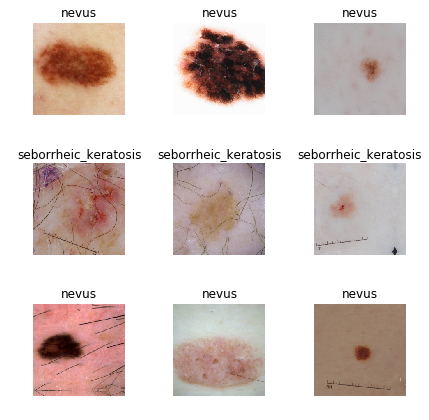

In [9]:
data.show_batch(rows=3, figsize=(6, 6))

## Resnet 34

### Train: Phase 1

In [10]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


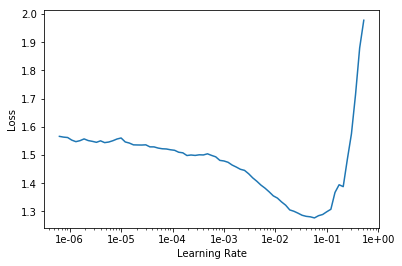

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(4, max_lr=1e-2)

epoch,train_loss,valid_loss,error_rate
1,1.057577,1.156643,0.320000
2,0.862302,0.797779,0.313333
3,0.724563,0.777061,0.340000
4,0.612935,0.723215,0.300000


In [13]:
learn.save('res34-frozen')

### Results

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(idxs)

True

In [ ]:
interp.plot_top_losses(9, figsize=(15, 11))

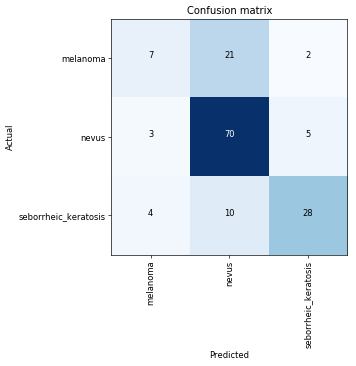

In [15]:
interp.plot_confusion_matrix(figsize=(6, 6), dpi=60)

## Unfrozen last layer

In [16]:
learn.load('res34-frozen')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (2000 items)
[Category seborrheic_keratosis, Category seborrheic_keratosis, Category seborrheic_keratosis, Category seborrheic_keratosis, Category seborrheic_keratosis]...
Path: ../data/melanoma-detection
x: ImageItemList (2000 items)
[Image (3, 2000, 3008), Image (3, 2000, 3008), Image (3, 2848, 4288), Image (3, 2592, 3872), Image (3, 2000, 3008)]...
Path: ../data/melanoma-detection;

Valid: LabelList
y: CategoryList (150 items)
[Category seborrheic_keratosis, Category seborrheic_keratosis, Category seborrheic_keratosis, Category seborrheic_keratosis, Category seborrheic_keratosis]...
Path: ../data/melanoma-detection
x: ImageItemList (150 items)
[Image (3, 1936, 2592), Image (3, 2848, 4288), Image (3, 2848, 4288), Image (3, 2592, 3872), Image (3, 1936, 2592)]...
Path: ../data/melanoma-detection;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [17]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.770283,31.956146,0.793333
2,0.735591,0.736495,0.286667


In [18]:
learn.fit_one_cycle(2, max_lr=slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.680537,0.780527,0.360000
2,0.647715,0.748704,0.273333


In [ ]:
learn.save('res34-unfrozen')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(idxs)

In [ ]:
interp.plot_top_losses(9, figsize=(15, 11))

In [ ]:
interp.plot_confusion_matrix(figsize=(6, 6), dpi=60)

## Training: resnet50

In [ ]:
data = (ImageItemList.from_folder(path)
        .random_split_by_pct(0.20)
        .label_from_folder()
        .transform(tfms, size=299)
        .databunch(bs=bs // 2)
        .normalize(imagenet_stats)
       )

In [ ]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8)

In [ ]:
learn.save('res50-frozen')

In [ ]:
learn.load('res50-frozen')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6, 1e-4))

If it doesn't, you can always go back to your previous model.

In [ ]:
learn.save('res50-unfrozen');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix(figsize=(6, 6), dpi=60)
# interp.most_confused(min_val=2)

In [ ]:
interp.plot_top_losses(9, figsize=(15, 11))